<a href="https://colab.research.google.com/github/badshahah/Breast-Cancer-Detection/blob/main/MobileNet_Breast_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


In [ ]:
# Define data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define data generator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Thesis Data/Dataset BDFF/train',
    target_size=(224, 224),  # Size should match the MobileNet input size
    batch_size=64,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Thesis Data/Dataset BDFF/val',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)


Found 1302 images belonging to 2 classes.
Found 372 images belonging to 2 classes.


In [ ]:
# Load MobileNetV2 with ImageNet weights, excluding the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,570,753 (13.62 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 226s 11s/step - accuracy: 0.8546 - loss: 0.6297 - val_accuracy: 1.0000 - val_loss: 0.0217
Epoch 2/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9688 - loss: 0.0889

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 871ms/step - accuracy: 0.9688 - loss: 0.0889 - val_accuracy: 0.9969 - val_loss: 0.0161
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9892 - loss: 0.0383 - val_accuracy: 0.9875 - val_loss: 0.0172
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9844 - loss: 0.0260 - val_accuracy: 0.9875 - val_loss: 0.0207
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9884 - loss: 0.0307 - val_accuracy: 0.9969 - val_loss: 0.0176
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9969 - val_loss: 0.0141
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9923 - loss: 0.0212 - val_accuracy: 0.9844 - val_loss: 0.0258
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.9812 - val_loss: 0.0277
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9897 - loss: 0.0247 - val_accuracy: 0.9969 - val_loss: 0

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy and loss from history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

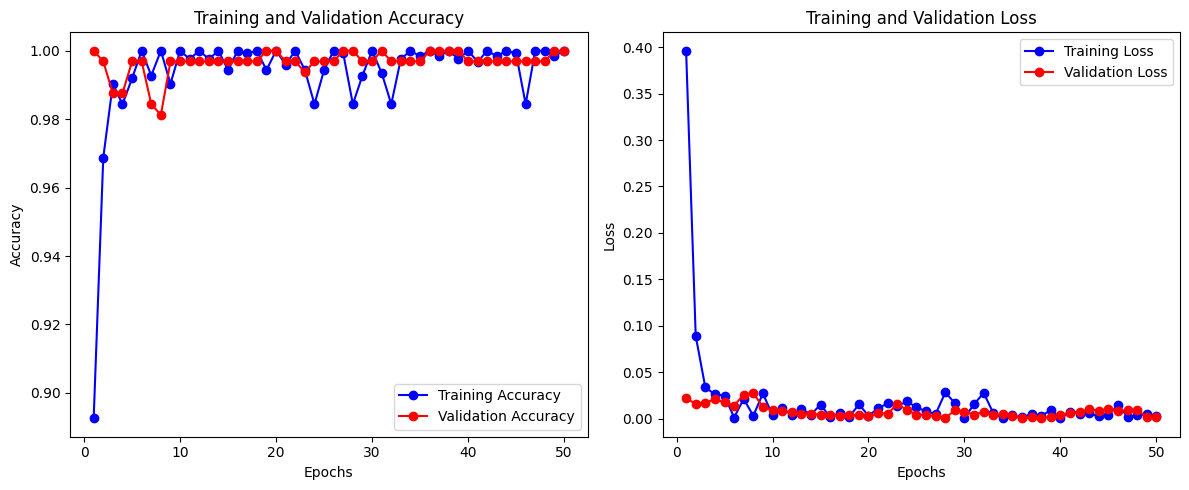

In [ ]:
# Extract training and validation accuracy and loss from history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Prepare the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Thesis Data/Dataset BDFF/test',  # Replace with your test directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for correct confusion matrix calculation
)


Found 187 images belonging to 2 classes.


In [ ]:
# Get predictions
test_generator.reset()  # Reset generator before prediction
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = (predictions > 0.5).astype("int32")

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


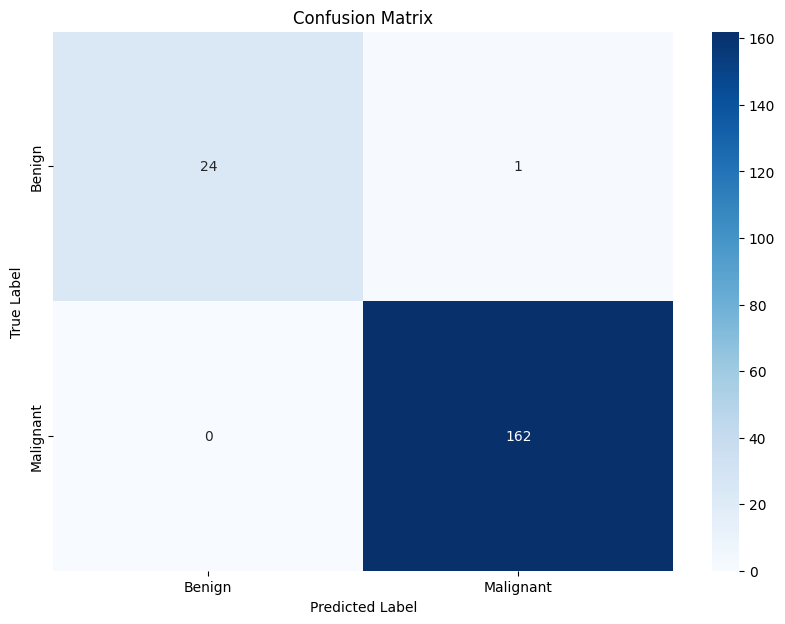

Confusion Matrix:
[[ 24   1]
 [  0 162]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.99      1.00      1.00       162

    accuracy                           0.99       187
   macro avg       1.00      0.98      0.99       187
weighted avg       0.99      0.99      0.99       187



In [ ]:
# Plot confusion matrix
import seaborn as sns # Import the seaborn library
from sklearn.metrics import confusion_matrix, classification_report # Import confusion_matrix and classification_report

# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(true_classes, predicted_classes)
class_report = classification_report(true_classes, predicted_classes)

plt.figure(figsize=(10, 7))

# Define class_labels (replace with your actual class names)
class_labels = ['Benign', 'Malignant']

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels) # Use conf_matrix instead of cm
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(class_report)